Understanding YOLO - https://hackernoon.com/understanding-yolo-f5a74bbc7967

In [2]:
# Import Important libraries

import os, sys
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, LeakyReLU
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import utils

In [3]:
train_images = '/home/mrityunjay/Documents/Object Detection - Project/dataset/train_images/'
test_images = '/home/mrityunjay/Documents/Object Detection - Project/dataset/test_images/'
xml_details = '/home/mrityunjay/Documents/Object Detection - Project/dataset/xml_details/'

## Resize images to (624, 624)

We will be using utils library, which consists of following functions -

1. <b>resize_multiple_images</b> - It resizes all the images in a folder
2. <b>rename_multiple_files</b> - It renames all the files in a folder (names starting from 0 upto the number of files present)
3. <b>xml_to_csv</b> - It extracts information from xml files and converts into xml files

In [3]:
utils.resize_multiple_images(train_images, train_images, (624, 624))

Processing...
Process Complete!
6 file(s) successfully resized.
Unable to resize 0 file(s).


## Convert xml files to csv

When the images are labelled, it generates a xml files which contains information about the bounding boxes and labels. To extract those information, we use the <b>xml_to_csv</b> function to convert xml file to csv file.

In [4]:
IMG_H, IMG_W = 624, 624

In [5]:
data = utils.xml_to_csv(xml_details)

In [6]:
data['x'] = (data['xmax'] + data['xmin'])/2/IMG_W
data['y'] = (data['ymax'] + data['ymin'])/2/IMG_H
data['w'] = (data['xmax'] - data['xmin'])/IMG_W
data['h'] = (data['ymax'] - data['ymin'])/IMG_H
data.set_index('filename', inplace = True)

In [7]:
data.loc['5.jpg']

,width,height,class,xmin,ymin,xmax,ymax,x,y,w,h
filename,,,,,,,,,,,
5.jpg,624,624,person,490,333,528,435,0.815705,0.615385,0.060897,0.163462
5.jpg,624,624,taxi,324,321,429,395,0.603365,0.573718,0.168269,0.118590
5.jpg,624,624,bike,118,360,171,398,0.231571,0.607372,0.084936,0.060897
5.jpg,624,624,person,89,344,103,399,0.153846,0.595353,0.022436,0.088141
5.jpg,624,624,cycle,229,362,284,395,0.411058,0.606571,0.088141,0.052885
5.jpg,624,624,cycle,551,359,583,384,0.908654,0.595353,0.051282,0.040064
5.jpg,624,624,person,558,342,575,378,0.907853,0.576923,0.027244,0.057692
5.jpg,624,624,person,250,336,267,385,0.414263,0.577724,0.027244,0.078526


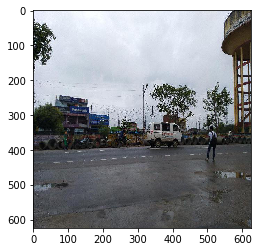

In [14]:
def fetch_images(path):
    for filename in os.listdir(path):
        img = Image.open(path + filename)
        yield filename, np.asarray(img)/255.0

images = {f:i for f,i in fetch_images(train_images)}
plt.imshow(images['5.jpg'])

<img src = 'yolo.png'>

## Architecture

### Loss Function

<img src = "yolo_loss_function.svg"/>

In [30]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = 'same', strides = 2, input_shape=(624,832,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(Conv2D(filters = 192, kernel_size = (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(Conv2D(filters = 128, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 256, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 512, kernel_size = (1,1), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(Conv2D(filters = 256, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 256, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 256, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 256, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 512, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 1024, kernel_size = (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(Conv2D(filters = 512, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 1024, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 512, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 1024, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 1024, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 1024, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 1024, kernel_size = (1,1), padding = 'same'))
model.add(LeakyReLU())

model.add(Conv2D(filters = 1024, kernel_size = (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Flatten())
model.add(Dense(4096))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dense(6859))

1. Train Your own Mask R-CNN using Pytorch :) https://www.kaggle.com/abhishek/train-your-own-mask-rcnn

2. Some Medium Posts - https://medium.com/@jonathan_hui/object-detection-series-24d03a12f904

3. Review of Deep Learning Algorithms for Object Detection - https://medium.com/zylapp/review-of-deep-learning-algorithms-for-object-detection-c1f3d437b852

4. Airplanes Detection for Satellite using Faster RCNN - https://towardsdatascience.com/airplanes-detection-for-satellite-using-faster-rcnn-d307d58353f1

5. YOLO object detection with OpenCV and Python - https://towardsdatascience.com/yolo-object-detection-with-opencv-and-python-21e50ac599e9

6. A Practical Guide to Object Detection using the Popular YOLO Framework – Part III (with Python codes) - https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/

7. How to implement a YOLO (v3) object detector from scratch in PyTorch: Part 1 - https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/

8. How to implement a YOLO (v3) object detector from scratch in PyTorch: Part 2 - https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-2/

9. How to implement a YOLO (v3) object detector from scratch in PyTorch: Part 3 - https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-3/

10. How to implement a YOLO (v3) object detector from scratch in PyTorch: Part 4 - https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-4/

11. Autonomous driving - Car detection - https://github.com/enggen/Deep-Learning-Coursera/blob/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/Autonomous%20driving%20application%20-%20Car%20detection%20-%20v1.ipynb